In [229]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import warnings

In [230]:
warnings.filterwarnings('ignore')

In [231]:
DATABASE_PATH = ''
df = pd.read_csv(DATABASE_PATH)

In [232]:
df.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [234]:
df.isnull().sum().sum()

0

In [235]:
df['class'].nunique()

3

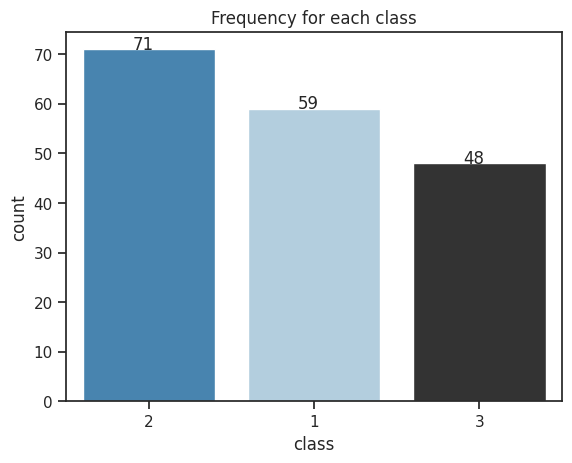

In [236]:
sns.set_theme(style='ticks')
ax = sns.countplot(x=df['class'],palette = 'Blues_d',order = df['class'].value_counts().index,hue=df['class'],legend=False)
ax.set_title('Frequency for each class')
for p in ax.patches:
  _x = p.get_x() + p.get_width() - 0.5
  _y = p.get_y() + p.get_height()
  value = int(p.get_height())
  ax.text(_x,_y,value,ha="left")
plt.show()

Here, we can observe an imbalance; we will use StratifiedKFold to resolve this.

# Analysing Features

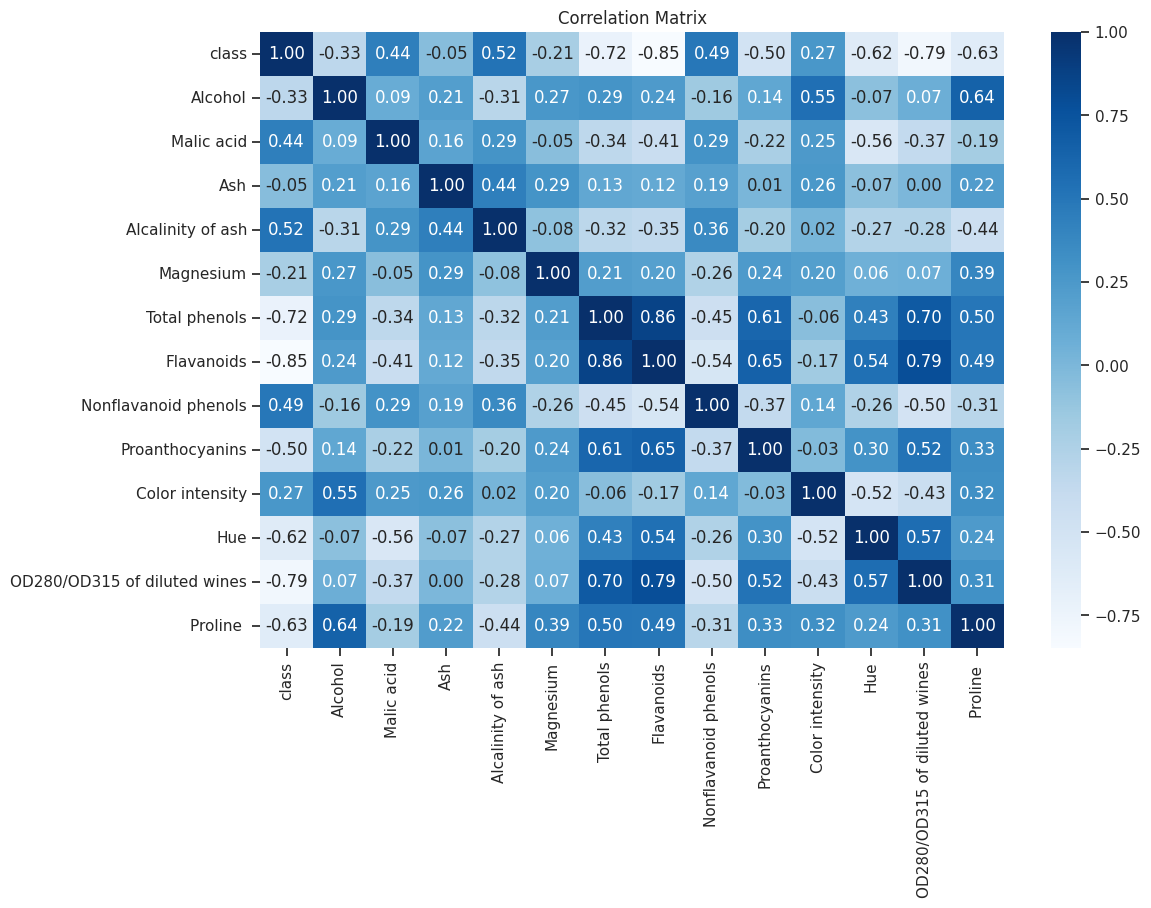

In [237]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(df.corr(numeric_only=True),annot=True,fmt='.2f',cmap='Blues')
ax.set_title('Correlation Matrix')
plt.show()

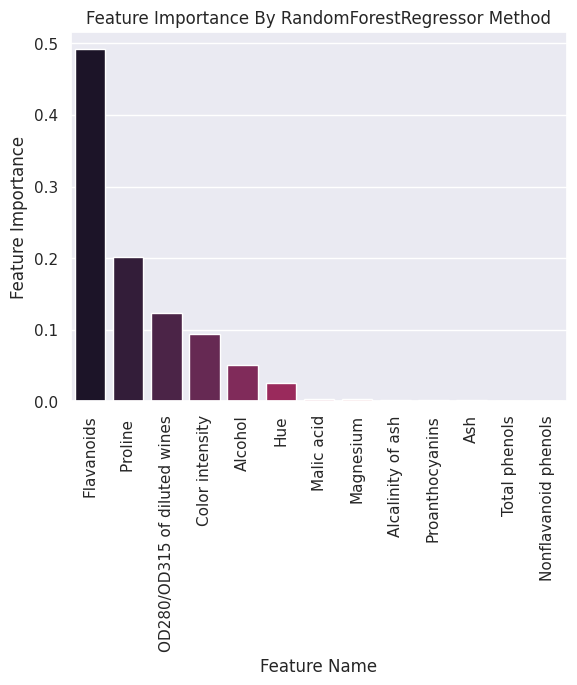

In [238]:
from sklearn.ensemble import RandomForestRegressor
columns = df.drop(['class'],axis=1).columns
X = df.drop(['class'],axis=1).values
y = df['class'].values
model = RandomForestRegressor()
model.fit(X,y)
features_series = pd.Series(data=model.feature_importances_,index=columns).sort_values(ascending=False)

sns.set_theme(style='darkgrid')
ax = sns.barplot(x=features_series.index,y=features_series,palette='rocket',hue=features_series.index,legend=False)
ax.set_title('Feature Importance By RandomForestRegressor Method')
ax.set_xlabel('Feature Name')
ax.set_ylabel('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# Transforming Data

In [239]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [240]:
X = df.drop(['class'],axis=1).values
y = df['class'].values
minmax = MinMaxScaler()
standard = StandardScaler()
X_minmax = minmax.fit_transform(X)
X_standard = standard.fit_transform(X)

In [241]:
ACTUAL_X = X_standard
ACTUAL_y = y

This configuration proves to be the best, but you can change the value to see other results for yourself.

# Defining helper functions and Training algs

In [242]:
algs_series = pd.Series(
    index=['SVC','Random Forest','KNN','Logistic Regression']
)

In [243]:
def find_best_params(estimator,params,X,y):
  cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=5)
  randomSearch = RandomizedSearchCV(
      estimator = estimator,
      param_distributions=params,
      random_state=5, # I like the number 5 :)
      cv=cv
  )
  randomSearch.fit(X,y)
  best_params = randomSearch.best_params_
  print(f'best_score:{randomSearch.best_score_*100:.2f}%')
  return best_params

In [244]:
def predict_and_return_score(estimator,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=5)
  estimator.fit(X_train,y_train)
  preds = estimator.predict(X_test)
  return eval(f'{accuracy_score(y_test,preds):.3f}')

# SVC

In [245]:
from sklearn.svm import SVC

In [246]:
params = {
    'C':np.logspace(-3,3,7),
    'gamma':np.logspace(-4,1,6),
    'kernel':['linear','poly','rbf','sigmoid'],
    'decision_function_shape':['ovo','ovr'],
    'random_state':[5]
}
best_params = find_best_params(SVC(),params,ACTUAL_X,ACTUAL_y)

best_score:98.33%


In [247]:
svc_final = SVC(**best_params)
algs_series['SVC'] = predict_and_return_score(svc_final,ACTUAL_X,ACTUAL_y)
algs_series['SVC']

0.944

# Random Forest

In [248]:
from sklearn.ensemble import RandomForestClassifier

In [249]:
params = {
    'n_estimators':range(100,600,50),
    'criterion':['gini','entropy','log_loss'],
    'random_state':[5]
}
best_params = find_best_params(RandomForestClassifier(),params,ACTUAL_X,ACTUAL_y)

best_score:98.30%


In [250]:
randomForest_final = RandomForestClassifier(**best_params)
algs_series['Random Forest'] = predict_and_return_score(randomForest_final,ACTUAL_X,ACTUAL_y)
algs_series['Random Forest']

1.0

# KNN

In [251]:
from sklearn.neighbors import KNeighborsClassifier

In [252]:
params = {
    'n_neighbors':range(1,10),
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
best_params = find_best_params(KNeighborsClassifier(),params,ACTUAL_X,ACTUAL_y)

best_score:97.19%


In [253]:
KNN_final = KNeighborsClassifier(**best_params)
algs_series['KNN'] = predict_and_return_score(KNN_final,ACTUAL_X,ACTUAL_y)
algs_series['KNN']

1.0

# Logistic Regression

In [254]:
from sklearn.linear_model import LogisticRegression

In [255]:
params = {
    'penalty':['none','l2','l1','elasticnet'],
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'C':np.logspace(-3,3,7)
}
best_params = find_best_params(LogisticRegression(),params,ACTUAL_X,ACTUAL_y)

best_score:98.89%


In [256]:
LR_final = LogisticRegression(**best_params)
algs_series['Logistic Regression'] = predict_and_return_score(LR_final,ACTUAL_X,ACTUAL_y)
algs_series['Logistic Regression']

1.0

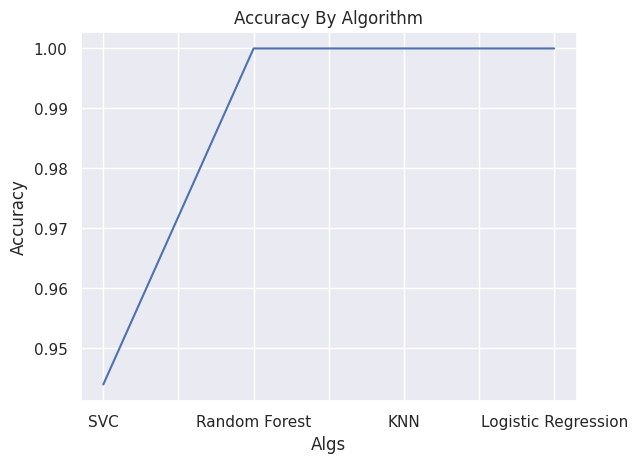

In [257]:
algs_series = algs_series.sort_values()
ax = algs_series.plot()
ax.set_title('Accuracy By Algorithm')
ax.set_xlabel('Algs')
ax.set_ylabel('Accuracy')
plt.show()